In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt
import importlib
import seaborn as sns
import sys

import layers_v2 as layers
import util as util
import networks as networks
import distributions

torch.set_default_dtype(torch.float64)

In [2]:
sys.path.insert(0, '../exp/')
import util as util_data

In [3]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)
importlib.reload(distributions)

<module 'distributions' from '/Users/beaucoker/Documents/git/VS-BNN/code/horseshoe/distributions.py'>

### Test LogitNormal

In [4]:
m = distributions.LogitNormal(torch.tensor([0.0]), torch.tensor([1.0]))
m.sample()

tensor([0.4725])

In [5]:
m1 = distributions.LogitNormal(torch.tensor([0.0]), torch.tensor([1.0]))
m2 = distributions.LogitNormal(torch.tensor([1.0]), torch.tensor([2.0]))

torch.distributions.kl_divergence(m1, m2)

tensor([0.4431])

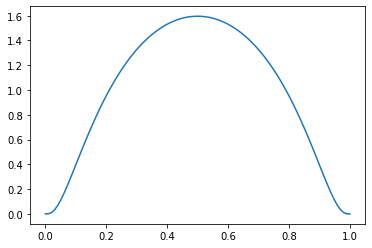

In [17]:
logit = lambda x: np.log(x/(1-x))

def logitnormal_pdf(x, mu=0, sig2=1):
    return 1/np.sqrt(2*np.pi*sig2)/(x*(1-x))*np.exp(-(logit(x)-mu)**2/(2*sig2))

eps = .0001
x = np.linspace(0+eps,1-eps,100)
plt.plot(x, logitnormal_pdf(x,0,1))

### Temp

In [20]:
a = nn.Parameter(torch.tensor(1.0))
b = a
a.data = torch.tensor(2.0)
b

Parameter containing:
tensor(2., requires_grad=True)

In [25]:
a = nn.Parameter(torch.tensor(1.0))
m = torch.distributions.normal.Normal(a, torch.tensor(3.0))
a.data = torch.tensor(2.0)
m.loc

Parameter containing:
tensor(2., requires_grad=True)

In [37]:
a = nn.Parameter(torch.tensor(-1.0))
t = torch.distributions.transforms.AbsTransform()
b = t(a)
a.data = torch.tensor(-2.0)
b

tensor(1., grad_fn=<AbsBackward>)

In [46]:
a = nn.Parameter(torch.tensor(-1.0))
t = torch.nn.Softplus()
b = t(a)
print(b)
a.data = torch.tensor(-2.0)
print(b)
print(t(a))

tensor(0.3133, grad_fn=<SoftplusBackward>)
tensor(0.3133, grad_fn=<SoftplusBackward>)
tensor(0.1269, grad_fn=<SoftplusBackward>)


In [29]:
b

tensor(1., grad_fn=<AbsBackward>)

In [57]:
loc = nn.Parameter(torch.tensor(0.0))
scale = nn.Parameter(torch.tensor(1.0))

loss = (1.0 - (loc + torch.randn(1)*scale))**2
loss.backward()
loc.grad

tensor(-2.4578)

In [59]:
loc = nn.Parameter(torch.tensor(0.0))
scale = nn.Parameter(torch.tensor(1.0))

m = torch.distributions.normal.Normal(loc,scale)

loss = (1.0 - m.rsample())**2
loss.backward()
loc.grad

tensor(-3.9945)

In [71]:
m = torch.distributions.normal.Normal(torch.tensor(0.0),torch.tensor(-100.0))
m.sample()

tensor(-17.6694)

In [88]:
torch.normal(torch.tensor(0.), torch.tensor(-1000.))

tensor(1120.5515)

In [90]:
torch.distributions.normal.Normal.arg_constraints['scale']

GreaterThan(lower_bound=0.0)

In [97]:
transform_to = torch.distributions.constraint_registry.ConstraintRegistry()

@transform_to.register(torch.distributions.constraints.positive)
def _transform_to_positive(constraint):
    return torch.distributions.transforms.ExpTransform()

In [99]:
constraint = torch.distributions.normal.Normal.arg_constraints['scale']
scale = transform_to(constraint)(torch.zeros(1))  # constrained
u = transform_to(constraint).inv(scale)

In [106]:
a = nn.Parameter(torch.tensor(-1.0))
scale = transform_to(constraint)(a)  # constrained
print(a)
print(torch.log(scale))
a.data = torch.tensor(-2.0)
print(a)
print(torch.log(scale))

Parameter containing:
tensor(-1., requires_grad=True)
tensor(-1., grad_fn=<LogBackward>)
Parameter containing:
tensor(-2., requires_grad=True)
tensor(-1., grad_fn=<LogBackward>)


In [ ]:
a = nn.Parameter(torch.tensor(-1.0))
t = torch.distributions.transforms.AbsTransform()
b = t(a)
a.data = torch.tensor(-2.0)
b

### SIN dataset

In [4]:
n_obs = 100
dim_in = 2
Z, X, Y, sig2 = util_data.load_data('sin', n_obs=n_obs, dim_in=dim_in, sig2=.01, seed=0)


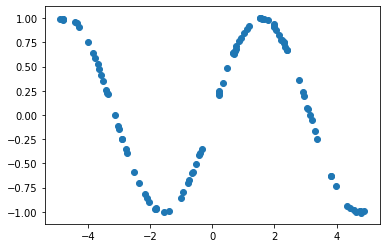

In [5]:
plt.scatter(Z[:,0],Y)

In [6]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)
importlib.reload(distributions)

<module 'distributions' from '/Users/beaucoker/Documents/git/VS-BNN/code/horseshoe/distributions.py'>

In [7]:
# logitnormal
torch.manual_seed(2)
model = networks.RffHs(dim_in, 1, dim_hidden=50, sig2_inv=1/sig2, \
                       layer_in_name='RffVarSelectLogitNormalLayer',\
                       s_loc_prior=0.5,
                       s_scale_prior=1.0)


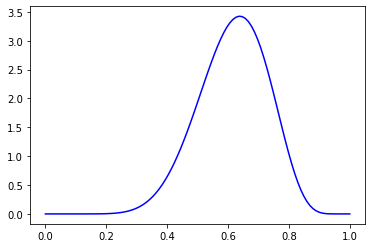

In [8]:
eps = .0001
x = np.linspace(0+eps,1-eps,100)

logit = lambda x: np.log(x/(1-x))

def logitnormal_pdf(x, mu=0, sig2=1):
    return 1/np.sqrt(2*np.pi*sig2)/(x*(1-x))*np.exp(-(logit(x)-mu)**2/(2*sig2))


loc = model.layer_in.s_loc_prior.item()
scale = model.layer_in.s_loc_prior.item()
plt.plot(x, logitnormal_pdf(x,loc,scale**2), color='blue',label='s0')

In [16]:
# beta
torch.manual_seed(2)
model = networks.RffHs(dim_in, 1, dim_hidden=50, sig2_inv=1/sig2, \
                       layer_in_name='RffVarSelectBetaLayer',\
                       s_a_prior=3,
                       s_b_prior=2)

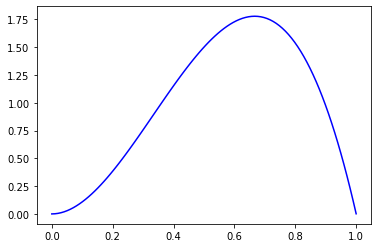

In [17]:
eps = .0001
x = np.linspace(0+eps,1-eps,100)
import scipy

a = model.layer_in.s_a_prior.item()
b = model.layer_in.s_b_prior.item()
plt.plot(x, scipy.stats.beta.pdf(x,a,b), color='blue',label='s0')


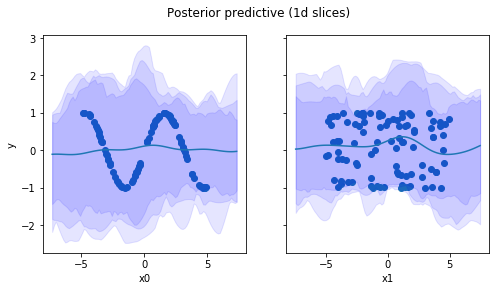

In [18]:
def sample_f_prior(x):
    with torch.no_grad():
        return model.forward(torch.from_numpy(x), weights_type_layer_in='sample_prior', weights_type_layer_out='sample_prior')

fig, ax = util.plot_slices(sample_f_prior, Z, Y, quantile=.5, n_samp=50, figsize=(4*2,4))


In [22]:
torch.manual_seed(2)
#optimizer = torch.optim.Adam(model.parameters(), lr=.001)
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)
model.reinit_parameters(torch.from_numpy(Z),torch.from_numpy(Y),n_reinit=10) 


In [23]:
for name, p in model.named_parameters():
    print(name, p.detach())

layer_in.s_a_trans tensor([1.0152, 1.0032])
layer_in.s_b_trans tensor([0.9959, 0.9905])


In [277]:
q = model.layer_in.get_variational()

In [286]:
q.sample((3,)).shape

torch.Size([3, 2])

In [285]:
q.sample().shape

torch.Size([2])

In [296]:
D = 2
K = 3
N = 4
S = 1

s = torch.ones((S,D))
w = torch.ones((K,D))
x = torch.ones((N,D))

xs = x.unsqueeze(1) * s.unsqueeze(0)

torch.squeeze(F.linear(xs,w)).shape

torch.Size([4, 3])

In [289]:
x.unsqueeze(1).shape

torch.Size([4, 1, 2])

In [294]:
s.unsqueeze(0).shape

torch.Size([1, 5, 2])

In [79]:
s.view(1,1,-1).

torch.Size([1, 1, 2])

In [76]:
x.shape

torch.Size([3, 1])

In [84]:
x = torch.tensor([[1], [2], [3]])

x.expand(-1, 4)

tensor([[1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3]])

In [77]:
x.expand(3, 4).shape

torch.Size([3, 4])

In [72]:
x = torch.tensor([[1,2,3]])
x.expand(3,1)

RuntimeError: The expanded size of the tensor (1) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [3, 1].  Tensor sizes: [1, 3]

In [260]:
# dimensions of m are observations
N = 5
S = 2
D = 1

loc = torch.randn((N,S,D)) # network output
scale = torch.tensor(1.0)

m = torch.distributions.normal.Normal(loc, scale)
[m.batch_shape, m.event_shape]

[torch.Size([5, 2, 1]), torch.Size([])]

In [274]:
data = torch.ones((N,D))
m.log_prob(data.unsqueeze(1)).shape

torch.Size([5, 2, 1])

In [275]:
m.log_prob(data.unsqueeze(1)).mean(1).sum(0)

tensor([-10.1184])

In [269]:
diagm = torch.distributions.independent.Independent(m,2)
[diagm.batch_shape, diagm.event_shape]

[torch.Size([5]), torch.Size([2, 1])]

In [270]:
data = torch.ones((N,S,D))
diagm.log_prob(data)

tensor([-3.5973, -5.4053, -3.3917, -3.4972, -4.3453])

In [224]:
# dimensions of m are observations
loc = torch.tensor([0.,0.])
scale = torch.tensor(1.0)

m = torch.distributions.normal.Normal(loc.view(-1), scale)
[m.batch_shape, m.event_shape]

[torch.Size([2]), torch.Size([])]

In [233]:
S = 5
y=torch.randn(S, 2) 
y

tensor([[ 0.1994, -1.3322],
        [ 0.3696, -0.4417],
        [ 1.0378,  0.1359],
        [ 0.0681, -1.8377],
        [-0.8369, -0.9166]])

In [234]:
m.log_prob(y)

tensor([[-0.9388, -1.8063],
        [-0.9872, -1.0165],
        [-1.4574, -0.9282],
        [-0.9213, -2.6076],
        [-1.2691, -1.3390]])

In [168]:
m.log_prob(y)

tensor([[-0.9634],
        [-0.9775]])

In [229]:
m.log_prob(y).mean(0).sum()

tensor(-2.1879)

In [152]:
y=torch.randn(2) # first dimension could be anything (like samples), second dimension is observations
y

tensor([0.4247, 0.7341])

In [154]:
m.log_prob(y.reshape(-1,1))

tensor([[-1.0091, -1.0091],
        [-1.1884, -1.1884]])

In [156]:
y.reshape(-1,1).shape

torch.Size([2, 1])

Epoch[1/1000], kl: 0.573797, likelihood: -1310.367418, elbo: 111.834159
Epoch[2/1000], kl: 0.571321, likelihood: -877.645412, elbo: -58946.244969
Epoch[3/1000], kl: 0.574738, likelihood: -17273.841023, elbo: -359.872489
Epoch[4/1000], kl: 0.581006, likelihood: -452.470264, elbo: -615.241990
Epoch[5/1000], kl: 0.582070, likelihood: -189.994895, elbo: -4195.440882
Epoch[6/1000], kl: 0.583131, likelihood: -61014.187880, elbo: -2935.154682
Epoch[7/1000], kl: 0.580934, likelihood: -1575.853025, elbo: -24321.995530
Epoch[8/1000], kl: 0.582117, likelihood: -38.681434, elbo: -4698.097777
Epoch[9/1000], kl: 0.582119, likelihood: 103.365444, elbo: -1722.591343
Epoch[10/1000], kl: 0.582327, likelihood: -992.346064, elbo: -5121.672134
Epoch[11/1000], kl: 0.582964, likelihood: -1492.318405, elbo: -1461.585353
Epoch[12/1000], kl: 0.582989, likelihood: -3901.430530, elbo: -22.910102
Epoch[13/1000], kl: 0.582941, likelihood: -4549.949886, elbo: -4707.135273
Epoch[14/1000], kl: 0.582701, likelihood: -2

Epoch[111/1000], kl: 0.798319, likelihood: -4954.212777, elbo: -4976.376154
Epoch[112/1000], kl: 0.797679, likelihood: -81506.664485, elbo: -86027.890270
Epoch[113/1000], kl: 0.809613, likelihood: -10089.211575, elbo: -1631.516705
Epoch[114/1000], kl: 0.812988, likelihood: -2349.683695, elbo: -3586.439471
Epoch[115/1000], kl: 0.812565, likelihood: -4575.099342, elbo: -5019.059932
Epoch[116/1000], kl: 0.813695, likelihood: -325.277847, elbo: -1923.195132
Epoch[117/1000], kl: 0.813122, likelihood: -28162.189064, elbo: -31505.861673
Epoch[118/1000], kl: 0.822601, likelihood: -1859.918669, elbo: -3862.718489
Epoch[119/1000], kl: 0.846325, likelihood: -5944.170142, elbo: -146.276887
Epoch[120/1000], kl: 0.847762, likelihood: -80024.515721, elbo: -3146.430024
Epoch[121/1000], kl: 0.856824, likelihood: -4697.073842, elbo: -60.406694
Epoch[122/1000], kl: 0.857425, likelihood: -5260.601989, elbo: -3692.975634
Epoch[123/1000], kl: 0.857009, likelihood: -14746.285901, elbo: -3368.392576
Epoch[124

Epoch[219/1000], kl: 1.510937, likelihood: -3010.855036, elbo: -20354.573083
Epoch[220/1000], kl: 1.512576, likelihood: -1889.281859, elbo: -3648.085643
Epoch[221/1000], kl: 1.518821, likelihood: -12566.012010, elbo: -22855.295408
Epoch[222/1000], kl: 1.522466, likelihood: -252037.972586, elbo: -176163.504610
Epoch[223/1000], kl: 1.569850, likelihood: -5132.971099, elbo: -1819.491645
Epoch[224/1000], kl: 1.574820, likelihood: -18224.063111, elbo: -152287.414504
Epoch[225/1000], kl: 1.602265, likelihood: -3965.163577, elbo: -16.563724
Epoch[226/1000], kl: 1.604656, likelihood: -22574.517158, elbo: -18842.619465
Epoch[227/1000], kl: 1.607283, likelihood: -2348.440762, elbo: -1924.892068
Epoch[228/1000], kl: 1.630483, likelihood: -134159.116088, elbo: -2818.919711
Epoch[229/1000], kl: 1.649639, likelihood: -959.411456, elbo: -3871.415108
Epoch[230/1000], kl: 1.651683, likelihood: -2684.499554, elbo: -4846.505104
Epoch[231/1000], kl: 1.651542, likelihood: -821.096011, elbo: -223.246850
Epo

Epoch[327/1000], kl: 2.754164, likelihood: -4322.508458, elbo: -4320.657647
Epoch[328/1000], kl: 2.757067, likelihood: -31750.422622, elbo: -26349.571463
Epoch[329/1000], kl: 2.774456, likelihood: -341.581991, elbo: -79.812236
Epoch[330/1000], kl: 2.774674, likelihood: -1540.927770, elbo: -136218.145642
Epoch[331/1000], kl: 2.829897, likelihood: -2780.655674, elbo: -2227.688729
Epoch[332/1000], kl: 2.839235, likelihood: -3093.730241, elbo: -2548.741849
Epoch[333/1000], kl: 2.839893, likelihood: -11116.910551, elbo: -21322.148028
Epoch[334/1000], kl: 2.856515, likelihood: -2860.766638, elbo: -123274.587827
Epoch[335/1000], kl: 2.904005, likelihood: -28468.102545, elbo: -3646.493224
Epoch[336/1000], kl: 2.912059, likelihood: -89853.613827, elbo: -3551.167653
Epoch[337/1000], kl: 2.939398, likelihood: -5973.515477, elbo: -3302.155165
Epoch[338/1000], kl: 2.952821, likelihood: -9288.591611, elbo: -2509.840488
Epoch[339/1000], kl: 2.960931, likelihood: -2590.321160, elbo: -1357.953732
Epoch

Epoch[435/1000], kl: 4.477213, likelihood: -19486.569924, elbo: -4527.568662
Epoch[436/1000], kl: 4.491320, likelihood: -45738.566289, elbo: -42691.705676
Epoch[437/1000], kl: 4.519043, likelihood: -2418.055727, elbo: -10304.152710
Epoch[438/1000], kl: 4.521928, likelihood: -6543.357706, elbo: -9222.985343
Epoch[439/1000], kl: 4.528565, likelihood: -2831.679649, elbo: -3263.388273
Epoch[440/1000], kl: 4.534940, likelihood: -2193.723882, elbo: -12648.373362
Epoch[441/1000], kl: 4.551483, likelihood: -67808.045081, elbo: -21782.790772
Epoch[442/1000], kl: 4.572432, likelihood: -1820.408939, elbo: -2529.762380
Epoch[443/1000], kl: 4.574312, likelihood: -5015.234123, elbo: -5181.635957
Epoch[444/1000], kl: 4.574548, likelihood: -2854.265136, elbo: -7143.279118
Epoch[445/1000], kl: 4.577929, likelihood: -2244.720393, elbo: -2406.518742
Epoch[446/1000], kl: 4.598201, likelihood: -3682.573835, elbo: -2690.507501
Epoch[447/1000], kl: 4.606258, likelihood: -4107.853052, elbo: -49284.253124
Epoc

Epoch[544/1000], kl: 6.628718, likelihood: -3438.538163, elbo: -2611.042705
Epoch[545/1000], kl: 6.633667, likelihood: -2558.314645, elbo: -309.606720
Epoch[546/1000], kl: 6.637563, likelihood: -5844.372012, elbo: -17324.455506
Epoch[547/1000], kl: 6.661311, likelihood: -3520.234572, elbo: -2507.564321
Epoch[548/1000], kl: 6.686241, likelihood: -2559.149608, elbo: -4387.304229
Epoch[549/1000], kl: 6.693076, likelihood: -11569.056855, elbo: -14176.410044
Epoch[550/1000], kl: 6.711536, likelihood: -190045.588772, elbo: -58691.679024
Epoch[551/1000], kl: 6.785225, likelihood: -2629.375560, elbo: -2056.103234
Epoch[552/1000], kl: 6.810752, likelihood: -2872.420847, elbo: -2381.069857
Epoch[553/1000], kl: 6.834935, likelihood: -13846.627487, elbo: -9403.768936
Epoch[554/1000], kl: 6.843308, likelihood: -2677.382597, elbo: -1978.753318
Epoch[555/1000], kl: 6.885304, likelihood: -2895.869642, elbo: -26186.664400
Epoch[556/1000], kl: 6.934937, likelihood: -3365.952081, elbo: -3787.808822
Epoch

Epoch[652/1000], kl: 8.978894, likelihood: -18659.534869, elbo: -2550.610135
Epoch[653/1000], kl: 8.984364, likelihood: -2259.122599, elbo: -2289.525738
Epoch[654/1000], kl: 8.984461, likelihood: -2742.631493, elbo: -6649.555084
Epoch[655/1000], kl: 8.979130, likelihood: -2374.928576, elbo: -2724.501943
Epoch[656/1000], kl: 9.054121, likelihood: -2426.247874, elbo: -5400.949123
Epoch[657/1000], kl: 9.094143, likelihood: -2368.939287, elbo: -2398.766121
Epoch[658/1000], kl: 9.115858, likelihood: -2444.253011, elbo: -3553.191009
Epoch[659/1000], kl: 9.166918, likelihood: -6879.884303, elbo: -8272.306012
Epoch[660/1000], kl: 9.175878, likelihood: -2484.774824, elbo: -2523.305797
Epoch[661/1000], kl: 9.177884, likelihood: -2384.891376, elbo: -2446.238665
Epoch[662/1000], kl: 9.214676, likelihood: -2485.935366, elbo: -2438.903060
Epoch[663/1000], kl: 9.231044, likelihood: -2437.728519, elbo: -2388.833695
Epoch[664/1000], kl: 9.250952, likelihood: -2306.982736, elbo: -2454.068559
Epoch[665/1

Epoch[759/1000], kl: 11.962901, likelihood: -2615.384262, elbo: -2629.250996
Epoch[760/1000], kl: 11.983944, likelihood: -14415.197746, elbo: -2751.952302
Epoch[761/1000], kl: 12.034158, likelihood: -2355.970891, elbo: -2751.984339
Epoch[762/1000], kl: 12.052706, likelihood: -2469.089618, elbo: -2465.192818
Epoch[763/1000], kl: 12.157840, likelihood: -4031.614851, elbo: -2867.296953
Epoch[764/1000], kl: 12.275537, likelihood: -2345.334677, elbo: -2396.402984
Epoch[765/1000], kl: 12.315288, likelihood: -2533.146544, elbo: -2553.909811
Epoch[766/1000], kl: 12.320571, likelihood: -2474.352218, elbo: -2278.305149
Epoch[767/1000], kl: 12.360866, likelihood: -16860.133322, elbo: -2366.562707
Epoch[768/1000], kl: 12.370260, likelihood: -7281.409340, elbo: -4707.261409
Epoch[769/1000], kl: 12.379653, likelihood: -2307.430994, elbo: -14073.950261
Epoch[770/1000], kl: 12.376464, likelihood: -2547.124146, elbo: -2559.374345
Epoch[771/1000], kl: 12.394751, likelihood: -294.454424, elbo: -2639.3292

Epoch[866/1000], kl: 15.383193, likelihood: -6279.886443, elbo: -2330.556017
Epoch[867/1000], kl: 15.395811, likelihood: -2238.080765, elbo: -3389.655046
Epoch[868/1000], kl: 15.414937, likelihood: -2299.068022, elbo: -2452.668180
Epoch[869/1000], kl: 15.434490, likelihood: -3066.331851, elbo: -2527.040002
Epoch[870/1000], kl: 15.440088, likelihood: -2445.677496, elbo: -5344.539578
Epoch[871/1000], kl: 15.479067, likelihood: -7235.786721, elbo: -2858.205245
Epoch[872/1000], kl: 15.502942, likelihood: -2475.455577, elbo: -11430.394961
Epoch[873/1000], kl: 15.500518, likelihood: -2291.378840, elbo: -2191.326958
Epoch[874/1000], kl: 15.504099, likelihood: -2565.820349, elbo: -2561.266599
Epoch[875/1000], kl: 15.512805, likelihood: -9073.075159, elbo: -9048.833337
Epoch[876/1000], kl: 15.560430, likelihood: -2418.899766, elbo: -2430.983084
Epoch[877/1000], kl: 15.616394, likelihood: -2843.384256, elbo: -2629.754128
Epoch[878/1000], kl: 15.628321, likelihood: -8419.603522, elbo: -2291.27376

Epoch[974/1000], kl: 19.650735, likelihood: -2298.920310, elbo: -10573.118115
Epoch[975/1000], kl: 19.662697, likelihood: -2427.574277, elbo: -3808.443365
Epoch[976/1000], kl: 19.670230, likelihood: -2415.788327, elbo: -2469.416918
Epoch[977/1000], kl: 19.674100, likelihood: -2499.512119, elbo: -2372.243099
Epoch[978/1000], kl: 19.681155, likelihood: -2379.580517, elbo: -2404.954144
Epoch[979/1000], kl: 19.751014, likelihood: -25554.682490, elbo: -6747.114250
Epoch[980/1000], kl: 19.858073, likelihood: -14097.555302, elbo: -2389.060982
Epoch[981/1000], kl: 19.880425, likelihood: -2460.101065, elbo: -2956.337154
Epoch[982/1000], kl: 19.888953, likelihood: -10170.602271, elbo: -3097.811839
Epoch[983/1000], kl: 19.948355, likelihood: -4053.447399, elbo: -2554.588460
Epoch[984/1000], kl: 19.967053, likelihood: -9890.111096, elbo: -4313.922205
Epoch[985/1000], kl: 20.021667, likelihood: -2506.358936, elbo: -2461.482018
Epoch[986/1000], kl: 20.086223, likelihood: -2374.325434, elbo: -15031.4

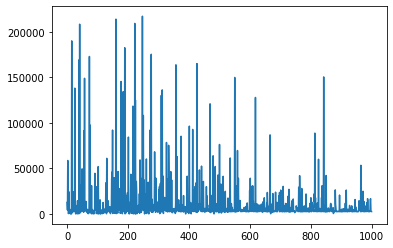

In [25]:
elbo = -networks.train(model, optimizer, torch.from_numpy(Z), torch.from_numpy(Y), n_epochs=1000, n_rep_opt=100, print_freq=1)
plt.plot(-elbo)

In [298]:
# logitnormal
eps = .0001
x = np.linspace(0+eps,1-eps,100)

logit = lambda x: np.log(x/(1-x))

def logitnormal_pdf(x, mu=0, sig2=1):
    return 1/np.sqrt(2*np.pi*sig2)/(x*(1-x))*np.exp(-(logit(x)-mu)**2/(2*sig2))


loc = model.layer_in.s_loc[0].detach().numpy()
scale = model.layer_in.transform(model.layer_in.s_scale_untrans[0]).detach().numpy()
plt.plot(x, logitnormal_pdf(x,loc,scale**2), color='blue',label='s0')

loc = model.layer_in.s_loc[1].detach().numpy()
scale = model.layer_in.transform(model.layer_in.s_scale_untrans[1]).detach().numpy()
plt.plot(x, logitnormal_pdf(x,loc,scale**2), color='red',label='s1')
plt.legend()


AttributeError: 'RffVarSelectBetaLayer' object has no attribute 's_loc'

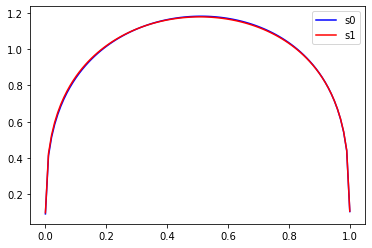

In [307]:
# beta
eps = .0001
x = np.linspace(0+eps,1-eps,100)
import scipy

a = model.layer_in.untransform(model.layer_in.s_a_trans[0]).detach().numpy()
b = model.layer_in.untransform(model.layer_in.s_b_trans[0]).detach().numpy()
plt.plot(x, scipy.stats.beta.pdf(x,a,b), color='blue',label='s0')

a = model.layer_in.untransform(model.layer_in.s_a_trans[1]).detach().numpy()
b = model.layer_in.untransform(model.layer_in.s_b_trans[1]).detach().numpy()
plt.plot(x, scipy.stats.beta.pdf(x,a,b), color='red',label='s1')

plt.legend()


In [300]:
def sample_f_post(x_test, x_train=torch.from_numpy(Z), y_train=torch.from_numpy(Y)):
    # inputs and outputs are numpy arrays
    #return model(torch.from_numpy(x), weights_type_layer_in='sample_post', weights_type_layer_out='sample_post').detach().numpy()

    # sample from variational dist then sample weights (conjugate)
    #model.fixed_point_updates(torch.from_numpy(Z),torch.from_numpy(Y)) 
    
    #return model(torch.from_numpy(x), weights_type_layer_in='stored', weights_type_layer_out='stored').detach().numpy()

    with torch.no_grad():
        return model.sample_posterior_predictive(x_test=torch.from_numpy(x_test), x_train=x_train, y_train=y_train).numpy().reshape(-1)


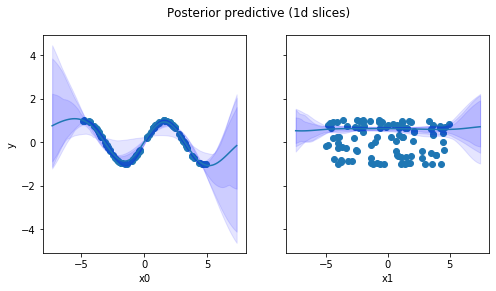

In [301]:
fig, ax = util.plot_slices(sample_f_post, Z, Y, quantile=.5, n_samp=50, figsize=(4*2,4))


#### GPy for comparison

In [29]:
import GPy
kernel = GPy.kern.RBF(input_dim=2, variance=1., lengthscale=1.)

In [30]:
m = GPy.models.GPRegression(Z,Y,kernel)

m.Gaussian_noise.variance = sig2
m.Gaussian_noise.fix()
m.optimize_restarts(num_restarts = 10, verbose=False)

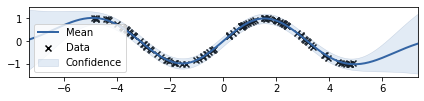

In [41]:
slices = [0]
figure = GPy.plotting.plotting_library().figure(3, 1)
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(1,y)], row=(i+1), plot_data=True)
#GPy.plotting.show(canvas, filename='basic_gp_regression_notebook_slicing')

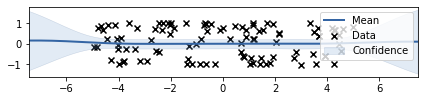

In [42]:
slices = [0]
figure = GPy.plotting.plotting_library().figure(3, 1)
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(0,y)], row=(i+1), plot_data=True)
#GPy.plotting.show(canvas, filename='basic_gp_regression_notebook_slicing_vertical')